# 1.0 Model : SRCNN w/o Data Augmentation

Let's replicate SRCNN architecture from paper https://arxiv.org/pdf/1501.00092.pdf

## 1.1 SRCNN Model(9-x-5) Class

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL

/home/mpershad/Documents/Python/SRCNN/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init

class SRCNN(nn.Module):

  """
  Model architecture(9-x-5) from original paper
  """

  def __init__(self, input_channels: int,
               hidden_units_1: int,
               hidden_units_2: int,
               kernel_sizes: list,
               padding: str,
               output_channels: int) -> None:

    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                  out_channels=hidden_units_1,
                  kernel_size=kernel_sizes[0],
                  padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units_1,
                  out_channels=hidden_units_2,
                  kernel_size=kernel_sizes[1],
                  padding=padding),
        nn.ReLU()
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units_2,
                  out_channels=output_channels,
                  kernel_size=kernel_sizes[2],
                  padding=padding)
    )
    self._intialize_weights()


  def _intialize_weights(self):

    for layer in self.modules():
      if isinstance (layer, nn.Conv2d):
        init.normal_(layer.weight, mean=0.0, std=0.001)
        if layer.bias is not None:
          init.zeros_(layer.bias)

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return x

### 1.1.0 Model Registry

In [4]:
class ModelRegistry:
  models = {}

  @classmethod
  def register_model(cls, name, model_class):
      cls.models[name] = model_class

  @classmethod
  def get_model(cls, name, *args, **kwargs):
      if name in cls.models:
          return cls.model[name](*args, **kwargs)
      raise ValueError(f"Model {name} not registered.")

### 1.1.1 Architecture

In [5]:
color_channel = int(input('Enter the number of color channel: '))

In [6]:
arch_input = input("Enter the SRCNN architecture as comma-separated filter sizes (e.g., '9,1,5'): ")
arch = [int(x.strip()) for x in arch_input.split(',')]

In [7]:
padding = input("Enter padding type ('same' or 'valid'): ").lower()

In [8]:
# Hyperparameters for Gaussian Blur
kernel_size = (5, 5)
sigma = 0.5
scale = 3

In [9]:
operation = input("Enter the operation that needs to performed on HR Image: ")

# Print message about the processing type
if operation == 'blur':
    print(f"Applying Gaussian Blur with kernel size {kernel_size} and sigma {sigma}.")
elif operation == 'downup':
    print("Applying Down-and-Up sampling.")
elif operation == 'both':
    print(f"Applying both Gaussian Blur with kernel size {kernel_size} and sigma {sigma}, and Down-and-Up sampling.")

Applying Down-and-Up sampling.


In [10]:
model_0 = SRCNN(input_channels=color_channel,
                   hidden_units_1=128,
                   hidden_units_2=64,
                   kernel_sizes=arch,
                   padding=padding,
                   output_channels=color_channel).to(device)

model_0

SRCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
)

## 1.2 Use `torchinfo` to get an idea of the shapes going through our model

In [11]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 33, 33])

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 33, 33]            --
├─Sequential: 1-1                        [1, 64, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 128, 33, 33]          31,232
│    └─ReLU: 2-2                         [1, 128, 33, 33]          --
│    └─Conv2d: 2-3                       [1, 64, 33, 33]           73,792
│    └─ReLU: 2-4                         [1, 64, 33, 33]           --
├─Sequential: 1-2                        [1, 3, 33, 33]            --
│    └─Conv2d: 2-5                       [1, 3, 33, 33]            4,803
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
Total mult-adds (M): 119.60
Input size (MB): 0.01
Forward/backward pass size (MB): 1.70
Params size (MB): 0.44
Estimated Total Size (MB): 2.15

## 1.3 Create train and test loop function

* `train_step()` - Takes in model and dataloader and trains the model on the dataloader

* `test_step()` - Take in model and dataloader and evaluatest the model on the dataloader

In [12]:
from typing import Tuple
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: str,
               max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single training step including forward pass, loss computation,
  backpropagation, and optimizer step.

  Parameters:
  - model (torch.nn.Module): The neural network model to be trained.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
  - loss_fn: Loss function used for training.
  - optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
  - device (str): Device to run the training on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - train_loss (float): Average training loss for this step.
  - train_psnr (float): Average Peak Signal-to-Noise Ratio (PSNR) for this step.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or optimizer are of the wrong type.
  """

  # Validate input parameters for type and value
  if not isinstance(model, torch.nn.Module):
    raise TypeError("model must be an instance of torch.nn.Module")
  if not isinstance(dataloader, torch.utils.data.DataLoader):
    raise TypeError("dataloader must be an instance of torch.utils.data.DataLoader")
  if not callable(loss_fn):
    raise TypeError("loss_fn must be callable")
  if not isinstance(optimizer, torch.optim.Optimizer):
    raise TypeError("optimizer must be an instance of torch.optim.Optimizer")
  if device not in ['cuda', 'cpu']:
    raise ValueError("device must be 'cuda' or 'cpu'")

  # Ensure model is on the correct device
  model.to(device)

  # Put the model in train mode
  model.train()

  # Setup train loss and PSNR
  train_loss = 0.0
  train_psnr = 0.0

  # Loop through batches of data
  for _, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate and accumulate PSNR
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
    train_psnr += psnr.item()

  # Adjust metrics to get average loss and PSNR per batch
  train_loss /= len(dataloader)
  train_psnr /= len(dataloader)

  return train_loss, train_psnr


In [13]:
from typing import Tuple
import torch

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              device: str,
              max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single evaluation step, calculating the average loss and PSNR
  over the provided dataloader.

  Parameters:
  - model (torch.nn.Module): The neural network model to be evaluated.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
  - loss_fn: The loss function used for evaluation.
  - device (str): The device to run the evaluation on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - test_loss (float): The average loss over the dataloader.
  - test_psnr (float): The average Peak Signal-to-Noise Ratio over the dataloader.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or device are of the wrong type.
  """

  # Validate input parameters
  if not isinstance(model, torch.nn.Module):
    raise TypeError("model must be an instance of torch.nn.Module")
  if not isinstance(dataloader, torch.utils.data.DataLoader):
    raise TypeError("dataloader must be an instance of torch.utils.data.DataLoader")
  if not callable(loss_fn):
    raise TypeError("loss_fn must be callable")
  if device not in ['cuda', 'cpu']:
    raise ValueError("device must be 'cuda' or 'cpu'")

  # Ensure model is on the correct device
  model.to(device)

  # Put the model in eval mode
  model.eval()

  test_loss = 0.0
  test_psnr = 0.0

  with torch.inference_mode():
    for _, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred = model(X)

      # Calculate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # Calculate PSNR
      psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
      test_psnr += psnr.item()

  # Compute average loss and PSNR
  test_loss /= len(dataloader)
  test_psnr /= len(dataloader)

  return test_loss, test_psnr


## 1.4 Checkpoint Saving Function

In [14]:
import torch
import os

def save_checkpoint(epoch, model, optimizer, loss, path="checkpoint.pth"):
  """
  Saves a checkpoint of the model and optimizer state.

  Parameters:
  - epoch: The current epoch number.
  - model: The model being trained.
  - optimizer: The optimizer being used for training.
  - loss: The loss value at the checkpoint.
  - path: The path to save the checkpoint to.
  """
  checkpoint = {
    'epoch': epoch + 1,  # Saving such that training can resume from the next epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
  }
  torch.save(checkpoint, path)
  print(f"Checkpoint saved at '{path}'")

## 1.5 Early Stopping and Best Model Saving

In [15]:
class EarlyStopping:

  def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pth'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.counter = 0
    self.path = path

  def __call__(self, val_loss, model, optimizer):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
          print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
      self.counter = 0

  def save_checkpoint(self, val_loss, model, optimizer):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, self.path)
    self.val_loss_min = val_loss

## 1.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [16]:
import os
import time
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn,
          path: str,
          start_epoch: int = 0,
          end_epoch: int = 200,
          checkpoint_interval=20,
          device: str = device):

  # Start the timer
  start_time = time.time()

  # 2. Create a empty result dicitonary
  results = {'train_loss': [],
            'val_loss' : [],
            'train_psnr': [],
            'val_psnr': []}

  # 3. Directory to save the model
  if not (os.path.exists("/home/mpershad/Documents/Python/SRCNN/Models")):
    os.makedirs("/home/mpershad/Documents/Python/SRCNN/Models")

  model_path = f"/home/mpershad/Documents/Python/SRCNN/Models/{path}.pth"
  
  # early_stopper = EarlyStopping(patience=200, verbose=True, delta=5e-6, path=model_path)

  total_epochs = end_epoch - start_epoch
  log_interval = total_epochs // 10 if total_epochs // 10 > 0 else 1
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(start_epoch, end_epoch)):

    train_loss, train_psnr = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)

    val_loss, val_psnr = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["train_psnr"].append(train_psnr)
    results["val_psnr"].append(val_psnr)

    # Log PSNR values
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_psnr': train_psnr, 'val_psnr': val_psnr})

    # Log values every 10% of the total epochs
    if epoch % log_interval == 0 or epoch == end_epoch - 1:
      
      # Print out what's happening
      print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | train_psnr: {train_psnr:.2f} dB | val_psnr: {val_psnr:.2f} dB")

    # early_stopper(val_loss, model, optimizer)
    # if early_stopper.early_stop:
    #     print("Early stopping")
    #     break

    # Checkpoint Saving
    if epoch % checkpoint_interval == 0 or epoch == end_epoch - 1:
      checkpoint_path = f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}/epoch_{epoch}.pth"

      if not (os.path.exists(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}")):
        os.makedirs(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/{path}")

      save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, loss=val_loss, path=checkpoint_path)
      # Optionally log checkpoint to wandb
      wandb.save(checkpoint_path)

  # 6. Use wandb.save() to ensure the model file is saved to W&B
  wandb.save(model_path)

  # 7. Log the model as an artifact
  artifact = wandb.Artifact('SRCNN', type='model', description="A super-resolution model")
  artifact.add_file(model_path)
  wandb.log_artifact(artifact)

  # 9. Calculate and log training duration
  end_time = time.time()
  total_training_time = end_time - start_time
  wandb.log({'total_training_time': total_training_time})

  # 10. Print the training time
  print(f"Total training time: {total_training_time:.3f} seconds")

  # 11. Remember to finish the W&B run
  wandb.finish()

  # 12. Return the results dict
  return results

## 1.7 Plot Loss Curves

A loss curve is a way of tracking your model's progress over time

In [17]:
def plot_loss_curves(results):
    """Plot training and validation loss curves and PSNR curves."""
    # Extract values from the results dictionary
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    train_psnr = results['train_psnr']
    val_psnr = results['val_psnr']

    # Calculate min and max values for loss and PSNR to dynamically set plot ranges
    min_loss = min(train_loss + val_loss)
    max_loss = max(train_loss + val_loss)
    min_psnr = min(train_psnr + val_psnr)
    max_psnr = max(train_psnr + val_psnr)

    # Setup the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Loss
    ax1.plot(train_loss, label='Training Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='red')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_ylim([min_loss - 0.05 * (max_loss - min_loss), max_loss + 0.05 * (max_loss - min_loss)])
    ax1.legend()

    # Plot PSNR
    ax2.plot(train_psnr, label='Training PSNR', color='blue')
    ax2.plot(val_psnr, label='Validation PSNR', color='red')
    ax2.set_title('PSNR Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('PSNR (dB)')
    ax2.set_ylim([min_psnr - 0.05 * (max_psnr - min_psnr), max_psnr + 0.05 * (max_psnr - min_psnr)])
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 2.0 Becoming one with the data(Pre Process and Explore)

## 2.1 Get the Data

In [18]:
def walk_through_dir(path : str) -> None:
  """
  Walk through Directory returning its content
  """

  for dirpath, dirname, filenames in os.walk(path):
    print(f"There are {len(filenames)} images in the {dirpath}")

In [19]:
image_path = '../Data/Train'
walk_through_dir(image_path)

There are 0 images in the ../Data/Train
There are 91 images in the ../Data/Train/HR
There are 21884 images in the ../Data/Train/pHR
There are 21884 images in the ../Data/Train/pLR


## 2.1 Visualizing the data

1. Get all the image paths
2. Pick a random image using `np.random.randint()`
3. Since we're working with images, let's open image with matplotlib
4. Show Image with Metadata

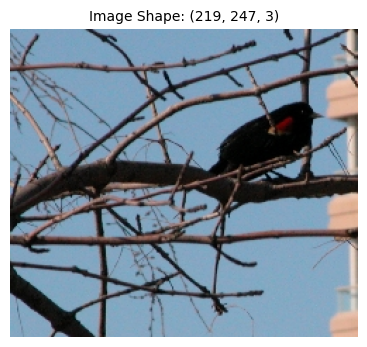

In [20]:
from PIL import Image
from pathlib import Path

# np.random.seed(42)

# Get posix path
image_path = '../Data/Train'
image_path = Path(os.path.join(image_path, "HR"))

# 1. Get all the image path
image_path = list(image_path.glob("*.bmp"))

# 2. Pick a radom image path
idx = np.random.randint(0, len(image_path))
random_img_path = image_path[idx]

# 3. Open Image
# random_img = plt.imread(random_img_path)
random_img = Image.open(random_img_path).convert('RGB')
random_img = np.array(random_img)

# Plot using matplotlib
plt.figure(figsize=(6,4))
plt.imshow(random_img)
plt.title(f"Image Shape: {random_img.shape}", fontsize=10) # shape: [height, width, color_chnanel]
plt.axis("off")
plt.show()

## 2.2 Image Quality Metrics

1. Mean Squared Error(MSE) :  MSE loss function is evaluated only by the difference between the central pixels of Xi and the network output.

$$
L(\Theta) = \frac{1}{n} \sum_{i=1}^n \left \| F(Y_i; \Theta) - X_i \right \|^2,
$$

where n is the number of training examples. Using MSE as the loss functiion favors a high PSNR.

Alternative evaluation metrics,

1. Peak Signal To Noise Ratio(PSNR)

2. Structural Similarity Index(SSIM)

### 2.2.1 Mean Squared Error(MSE)

In [21]:
import numpy as np

def mse(original : np.ndarray, target : np.ndarray) -> float:

  """
  Compute the Mean Squared Error (MSE) between two images.

  Parameters:
  original (np.ndarray): The original image, expected to be a numpy array.
  compressed (np.ndarray): The compressed or modified image, expected to be a numpy array.

  Returns:
  float: The MSE value.
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  return mse

### 2.2.2 Peak Signal To Noise Ratio(PSNR)

In [22]:
import numpy as np

def psnr(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Peak Signal to Noise Ratio (PSNR) between two images.

  Parameters:
  original (numpy.ndarray): The original image.
  compressed (numpy.ndarray): The compressed or modified image.

  Returns:
  float: The PSNR value in decibels (dB).
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  if mse == 0:
    # MSE is zero means no noise is present in the signal.
    # Therefore, PSNR is infinite.
    return float('inf')

  max = 255.0
  psnr_val = 20*np.log10(max / np.sqrt(mse))
  return psnr_val

### 2.2.3 Structural Similarity Index(SSIM)

In [23]:
from skimage.metrics import structural_similarity as ssim_lib
from skimage.color import rgb2gray
import numpy as np

def ssim(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Structural Similarity Index (SSIM) between two images.

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Returns:
  float: The SSIM value.
  """

  # Convert images to grayscale if they are in color because SSIM is often computed in grayscale
  if original.ndim == 3:
    original = rgb2gray(original)
  if target.ndim == 3:
    target = rgb2gray(target)

  # Dynamically determine the data range for SSIM calculation
  # If the images are floating point, assume they are in [0, 1]
  if original.dtype == np.float32 or original.dtype == np.float64:
      data_range = 1
  else:
      # For integer types, use the maximum possible value of the dtype
      data_range = np.iinfo(original.dtype).max
  
  ssim_value, _ = ssim_lib(original, target, data_range=data_range, full=True)
  return ssim_value

### 2.2.4 Combined Metric

In [24]:
from typing import Tuple
import numpy as np

def combined_metric(original : np.ndarray, target : np.ndarray) -> Tuple:
  """
  Combined metric using MSE, PSNR and SSIM

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Return:
  Tuple: (MSE, PSNR, SSIM)
  """

  mse_val = mse(original, target)
  psnr_val = psnr(original, target)
  ssim_val = ssim(original, target)

  return (mse_val, psnr_val, ssim_val)

# 3.0 Transforming Data

To prepare our dataset for training a Super-Resolution CNN (SRCNN), we need to simulate low-resolution (LR) images from our high-resolution (HR) images. The following steps are taken for each image in our HR dataset:




## 3.1 LR Transformations

1. **Apply Gaussian Blur**:
   A Gaussian blur is applied to the HR images. This step is performed to smooth out the images and simulate the loss of detail that occurs in a real-world low-resolution image.

2. **Downscale**:
   The blurred HR images are then downsampled by a specified upscale factor.

3. **Upscale**:
   The downsampled images are then upscaled back to the original dimensions using bicubic interpolation.

4. **Save Processed Images**:
  The processed LR images are saved back to the filesystem for use in training the SRCNN.

In [25]:
import cv2 as cv
import numpy as np
from typing import Tuple

def generate_lr_image(image: np.ndarray, operation: str, scale: int, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0) -> np.ndarray:
  """
  Processes the low-resolution image based on the specified operation: Gaussian Blur, Down-and-Up sampling, or both,
  for both grayscale and color images.

  Parameters:
  - image (np.ndarray): The input image to process. Can be grayscale or color.
  - operation (str): The operation to perform - 'blur', 'downup', 'both'.
  - scale (int): The downscaling factor for down-and-up sampling.
  - kernel_size (Tuple[int, int]): The kernel size for Gaussian blur.
  - sigma (float): The sigma value for Gaussian blur.

  Returns:
  - np.ndarray: Low-resolution image.
  """
  # Check if the image is grayscale or color
  if len(image.shape) == 2:
    # Grayscale image
    h, w = image.shape
  else:
    # Color image
    h, w, _ = image.shape

  lr_image = image

  if operation in ['blur', 'both']:
    # Apply Gaussian Blur
    lr_image = cv.GaussianBlur(lr_image, kernel_size, sigma)

  if operation in ['downup', 'both']:
    # Downscale and then upscale
    if len(image.shape) == 2:
      # Grayscale
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)
    else:
      # Color
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)

  return lr_image

In [26]:
# Setup train Paths
image_path = '../Data/Train'
hr_train_path = os.path.join(str(image_path), "HR")
# lr_train_path = os.path.join(str(image_path), "LR")
hr_train_path 

'../Data/Train/HR'

In [27]:
# Setup test Paths
test_image_path = '../Data/Test'
hr_test_path = os.path.join(str(test_image_path), "HR")
# lr_test_path = os.path.join(str(test_image_path), "LR")
hr_test_path 

'../Data/Test/HR'

In [28]:
from PIL import Image

def plot_hr_lr_images(hr_img_dir: str, n: int = 3, seed=52):
  if seed:
    np.random.seed(seed)

  plt.figure(figsize=(10, 10))

  random_idx_list = list(np.random.randint(0, len(os.listdir(hr_img_dir)), n))

  for i, idx in enumerate(random_idx_list):
    hr_img_path = os.path.join(hr_img_dir, os.listdir(hr_img_dir)[idx])
    # lr_img_path = os.path.join(lr_img_dir, os.listdir(lr_img_dir)[idx])

    # hr_img = plt.imread(hr_img_path)
    # lr_img = plt.imread(lr_img_path)

    hr_img = Image.open(hr_img_path).convert('RGB')
    # lr_img = Image.open(lr_img_path).convert('RGB')

    hr_img = np.array(hr_img)
    # lr_img = np.array(lr_img)
    lr_img = generate_lr_image(hr_img, operation, scale, kernel_size, sigma)

    # Calculate the combined metrics
    metrics = combined_metric(hr_img, lr_img)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(hr_img)
    plt.title(f"HR Image\nSize: {hr_img.shape}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(lr_img)
    plt.title(f"LR Image\nSize: {lr_img.shape}", fontsize=8)
    plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
    plt.xticks([])
    plt.yticks([])
    # plt.axis("off")

  plt.tight_layout()
  plt.show()

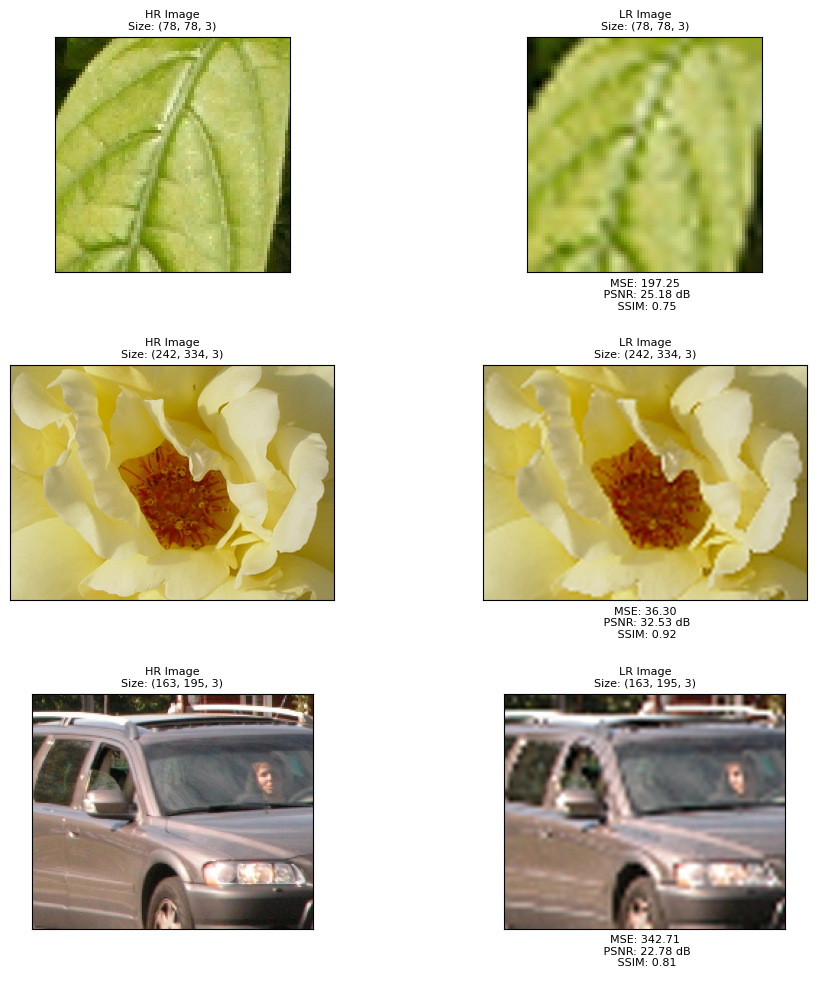

In [29]:
plot_hr_lr_images(hr_img_dir = hr_train_path,
                  n = 3)

## 3.2 Modcrop

In [30]:
def modcrop(img, modulo):

  if img.ndim == 2:
    sz = img.shape
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1]]
  elif img.ndim == 3:
    sz = img.shape[0:2]
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1], :]
  else:
    raise ValueError("Unsupported image dimensions")

  return img_cropped

## 3.3 Sub Images using different blurring options(From Authors)

In [31]:
import os
import sys
import cv2 as cv
import numpy as np
import argparse
from PIL import Image
from typing import Tuple

def generate_patches(filepath: str, patches_label_dir: str, patches_data_dir: str, operation: str, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0, size_input:int = 33, scale:int = 3, stride:int = 14, padding: str = 'valid', color_channel: int = 1):
  """
  Generates training patches from a single image file and saves them to specified directories.

  This function takes an image file, processes it to generate low-resolution (LR) and high-resolution (HR) patches, and saves these patches as individual image files in specified directories. LR patches are generated by downsampling and then upsizing the original HR image using bicubic interpolation. The function then extracts patches of specified sizes from both the LR and HR images using a specified stride.

  Parameters:
  - filename (str): Path to the original HR image file.
  - patches_label_dir (str): Directory path where HR (label) patches will be saved.
  - patches_data_dir (str): Directory path where LR (input/data) patches will be saved.
  - size_input (int, optional): Size of the LR patches. Default is 33.
  - scale (int, optional): Factor by which the HR image is downsampled to generate the LR image. Default is 3.
  - stride (int, optional): Stride with which patches are extracted from the images, controlling the overlap. Default is 14.
  - padding (str, optional): Padding type for the model ('same' or 'valid'). Default: 'valid'.
  - color_channel (int, optional): Number of color channels in the image. Default: 1.

  Returns:
  - int: The total number of patches generated from the image.

  Raises:
  - TypeError: If the input image is not a PIL Image object.
  """
  # Create directories for patches if they don't exist
  os.makedirs(patches_label_dir, exist_ok=True)
  os.makedirs(patches_data_dir, exist_ok=True)

  filename = os.path.basename(filepath).split('.')[0]

  # Calculate size_label based on padding
  if padding == 'same':
    size_label = size_input
  else:
    size_label = size_input - sum([f - 1 for f in arch])

  pad = (size_input - size_label) // 2

  img = Image.open(filepath).convert('RGB')

  if not isinstance(img, Image.Image):
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

  # Handle color images
  if color_channel == 3:
    img = np.array(img)  # Convert to NumPy array
  else:
    img_ycbcr = img.convert('YCbCr')
    img = np.array(img_ycbcr)[:, :, 0]  # Extract Y channel

  im_label = modcrop(img, scale)
  h, w = im_label.shape[:2]
  total_patches = 0

  # Process the image for low-resolution version
  im_input = generate_lr_image(im_label, operation, scale, kernel_size, sigma)

  # Save each patch to the respective directories
  for x in range(0, h-size_input+1, stride):
    for y in range(0,  w-size_input+1, stride):
      # Extract the data and label patch
      data_patch = im_input[x:x+size_input, y:y+size_input]
      label_patch = im_label[x+pad:x+pad+size_label, y+pad:y+pad+size_label]

      # Convert patches back to images
      data_patch_img = Image.fromarray(data_patch)
      label_patch_img = Image.fromarray(label_patch)

      total_patches += 1

      # Save the patch
      data_patch_img.save(os.path.join(patches_data_dir, f'{filename}_{x}_{y}.png'))
      label_patch_img.save(os.path.join(patches_label_dir, f'{filename}_{x}_{y}.png'))

  return total_patches

In [32]:
# Generating training data

train_data_dir = "../Data/Train/HR"
size_input = 33
stride = 14

total = 0
for filename in os.listdir(train_data_dir):
  filepath = os.path.join(train_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Train/pHR',
            patches_data_dir='../Data/Train/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            scale=scale,
            stride=stride,
            padding=padding,
            color_channel=color_channel)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

Generated 435 patches from t37.bmp
Generated 81 patches from t17.bmp
Generated 312 patches from t66.bmp
Generated 112 patches from t32.bmp
Generated 156 patches from t25.bmp
Generated 49 patches from t23.bmp
Generated 56 patches from t10.bmp
Generated 609 patches from tt25.bmp
Generated 192 patches from t47.bmp
Generated 132 patches from t1.bmp
Generated 72 patches from t30.bmp
Generated 330 patches from t49.bmp
Generated 400 patches from tt27.bmp
Generated 120 patches from tt18.bmp
Generated 144 patches from t44.bmp
Generated 110 patches from t2.bmp
Generated 42 patches from t9.bmp
Generated 63 patches from t26.bmp
Generated 110 patches from t6.bmp
Generated 90 patches from t14.bmp
Generated 81 patches from t5.bmp
Generated 575 patches from tt6.bmp
Generated 380 patches from tt23.bmp
Generated 560 patches from tt8.bmp
Generated 187 patches from tt14.bmp
Generated 198 patches from t54.bmp
Generated 136 patches from t61.bmp
Generated 144 patches from t57.bmp
Generated 16 patches from t2

In [33]:
# Generating Validation data

validation_data_dir = "../Data/Test/HR"
size_input = 33
stride = 21

total = 0
for filename in os.listdir(validation_data_dir):
  filepath = os.path.join(validation_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Validation/pHR',
            patches_data_dir='../Data/Validation/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            scale=scale,
            stride=stride,
            padding=padding,
            color_channel=color_channel)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

Generated 121 patches from butterfly_GT.bmp
Generated 720 patches from ppt3.bmp
Generated 208 patches from coastguard.bmp
Generated 506 patches from baboon.bmp
Generated 486 patches from zebra.bmp
Generated 828 patches from monarch.bmp
Generated 144 patches from face.bmp
Generated 208 patches from foreman.bmp
Generated 858 patches from barbara.bmp
Generated 150 patches from woman_GT.bmp
Generated 176 patches from comic.bmp
Generated 529 patches from man.bmp
Generated 144 patches from head_GT.bmp
Generated 368 patches from flowers.bmp
Generated 529 patches from bridge.bmp
Generated 529 patches from pepper.bmp
Generated 529 patches from baby_GT.bmp
Generated 529 patches from lenna.bmp
Generated 169 patches from bird_GT.bmp
Total patches generated: 7731


## 3.4 Plot image and patches

In [34]:
%%capture
!pip install patchify

In [35]:
import numpy as np
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt

def plot_image_with_all_patches(img_path: str, patch_size: tuple, step: int) -> None:
  """
  Generates patches for an image using patchify and plots them alongside the original image.

  Parameters:
  img_path (str): Path to the image file.
  patch_size (tuple): The size of the patches (width, height).
  step (int): The step size for the sliding window when patchifying.
  """
  # Load the image
  img = Image.open(img_path)
  img_array = np.array(img)

  # Generate patches
  patches = patchify(img_array, patch_size + (3,), step=step)

  # Calculate the layout for plotting
  num_patches = patches.shape[0] * patches.shape[1]
  num_columns = patches.shape[1]
  num_rows = patches.shape[0]

  # Plot the original image
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.title(f"Size: {img_array.shape}", fontsize=8)
  plt.axis('off')
  # plt.show()

  # Create a new figure for patches
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(5, 5))

  # Ensure we have a 2D axes array for single row/column
  if num_rows == 1 or num_columns == 1:
    axes = np.array(axes).reshape(num_rows, num_columns)

  # Plot each patch
  for i in range(num_rows):
    for j in range(num_columns):
        patch_img = patches[i, j, 0]
        axes[i, j].imshow(patch_img)
        axes[i, j].axis('off')

  # Adjust the spacing
  plt.subplots_adjust(wspace=0.1, hspace=0.05)
  # Alternatively, you can use tight_layout with parameters
  # plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

  plt.show()

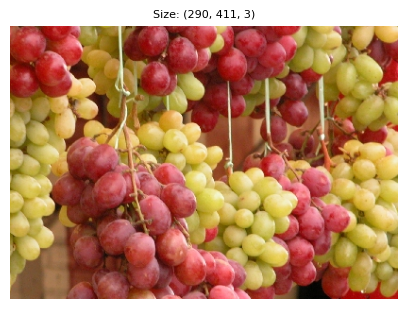

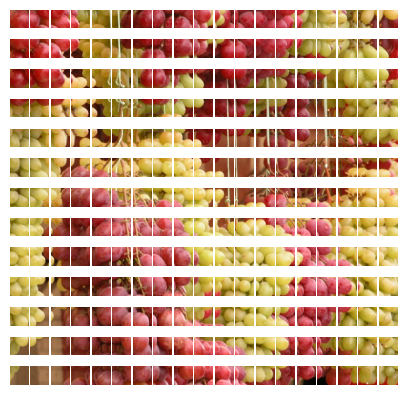

In [36]:
np.random.seed(42)

hr_img_paths = list(os.listdir(hr_train_path))
patch_size = (33, 33)

# Select random index and plot image along with patches
idx = int(np.random.randint(0, len(hr_img_paths), 1))
random_img_path = os.path.join(hr_train_path, hr_img_paths[idx])

plot_image_with_all_patches(random_img_path, patch_size, stride)

# 4.0 Loading Images data with custom 'Dataset'

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directories(the directory we'd like to get data from) as well as a transfrom if we'd like to transform out data
3. Create several attribute:
  * lr and hr path of our images
  * tranform - The transfrom we'd like to use
4. Create a function to `load_image()`, this function will open the image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

### 4.0.1 Transform for No Blurring(From Author)

In [37]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List

class SRCNNDataset(Dataset):

  # 2. Initialize with a lr/hr_img_dir and transform(optional) parameter
  def __init__(self, lr_img_dir : str, hr_img_dir : str, ext : str,transform = None):

    # 3. Create class attributes
    self.img_paths = sorted(list(Path(lr_img_dir).glob(f"*.{ext}")))
    self.label_paths = sorted(list(Path(hr_img_dir).glob(f"*.{ext}")))

    # Setup transform
    self.transform = transform


  # Make function to load images
  def load_target(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    target_path = self.img_paths[idx]
    return Image.open(target_path)

  def load_label(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    label_path = self.label_paths[idx]
    return Image.open(label_path)

  # Overwrite the __len()__ method
  def __len__(self)-> int:

    "Returns the total number of samples."
    return len(self.img_paths)

  def __getitem__(self, idx : int) -> Tuple[torch.tensor, torch.tensor]:

    """Returns one sample of data, data and label (X, y)"""
    img = self.load_target(idx)
    target = self.load_label(idx)

    # Transform if necessary
    if self.transform:
      img = self.transform(img)
      target = self.transform(target)

    return img, target # return data, label (X, y)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [38]:
def rgb_to_ycrcb(img: Image.Image) -> Image.Image:
    """
    Convert an RGB image to YCrCb and extract the Y channel.
    """
    if not isinstance(img, Image.Image):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    ycrcb_img = img.convert('YCbCr')
    y, _, _ = ycrcb_img.split()
    return y

In [39]:
from torchvision import transforms
# Augment train data
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

validation_transform = transforms.Compose([
    transforms.ToTensor()
])

In [40]:
train_imgs = '../Data/Train/pLR'
train_labels = '../Data/Train/pHR'

val_imgs = '../Data/Validation/pLR'
val_labels = '../Data/Validation/pHR'

# test_imgs = 'SRCNN/Data/Test/LR'
# test_labels = 'SRCNN/Data/Test/HR'

train_data_custom = SRCNNDataset(lr_img_dir = train_imgs,
                          hr_img_dir = train_labels,
                          ext = "png",
                          transform = train_transform)

validation_data_custom = SRCNNDataset(lr_img_dir = val_imgs,
                          hr_img_dir = val_labels,
                          ext = "png",
                          transform = validation_transform)

train_data_custom, validation_data_custom

(<__main__.SRCNNDataset at 0x7f537300a640>,
 <__main__.SRCNNDataset at 0x7f53732faa60>)

In [41]:
print(f"Length of Training Data: {len(train_data_custom)}")
print(f"Length of Training Data: {len(validation_data_custom)}")
# print(f"Length of Test Data: {len(test_data_custom)}")

Length of Training Data: 21884
Length of Training Data: 7731


## 4.1 Turn custom loaded images into DataLoader's

In [42]:
import os
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64

# Split the validation dataset(Too big validation)
validation_size = int(1.0 * len(validation_data_custom))  # 50% for validation
rest_validation_size = len(validation_data_custom) - validation_size
validation_dataset = random_split(validation_data_custom, [rest_validation_size, validation_size])

# Create dataloaders for each set
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     num_workers=os.cpu_count(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

validation_dataloader_custom = DataLoader(dataset=validation_data_custom,
                                          num_workers=os.cpu_count(),
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

train_dataloader_custom, validation_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f537e943760>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5322c574c0>)

In [43]:
# Get first batch of image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out shape
print(f"Image Batch shape: {img_custom.shape} ->[batch_size, color_channel, height, width]")
print(f"Label Shape: {label_custom.shape}")

Image Batch shape: torch.Size([64, 3, 33, 33]) ->[batch_size, color_channel, height, width]
Label Shape: torch.Size([64, 3, 33, 33])


## 4.2 Create a function to display random images

1. Take `Dataset` and `n` number of images to display
2. To prevent display getting out of hand, we'll cap `n` to 10 iamges
3. Set the random seed
4. Get a list of random indexes for plotting
5. Setup `matplotlib` plot
6. Loop through random list of index found in Step : 4  and plot them with `matplotlib`
7. Make sure the images are of right shape before we plot them.

In [44]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n is high
  if n > 5:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")


  if seed:
    torch.manual_seed(seed)

  # 3. Get random sample of indexes
  random_samples_idx = torch.randint(0, len(dataset), size=([1, n])).tolist()[0]

  # 4. Setup plot
  plt.figure(figsize=(6,18))

  # 5. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample]

    # 6. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channel]
    targ_img = targ_img.permute(1, 2, 0)
    targ_label = targ_label.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(targ_img, cmap="gray")
    if display_shape:
      plt.title(f"LR Image\nSize: {targ_img.shape}", fontsize = 8)
      mse_val = mse(targ_img.numpy(), targ_label.numpy())
      psnr_val = psnr(targ_img.numpy(), targ_label.numpy())
      metrics_str = f"MSE: {mse_val:.2f}\n PSNR: {psnr_val:.2f} dB\n"
      plt.xlabel(metrics_str, fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(targ_label, cmap="gray")
    if display_shape:
      plt.title(f"HR Image\nSize: {targ_label.shape}", fontsize = 8)
    plt.xticks([])
    plt.yticks([])

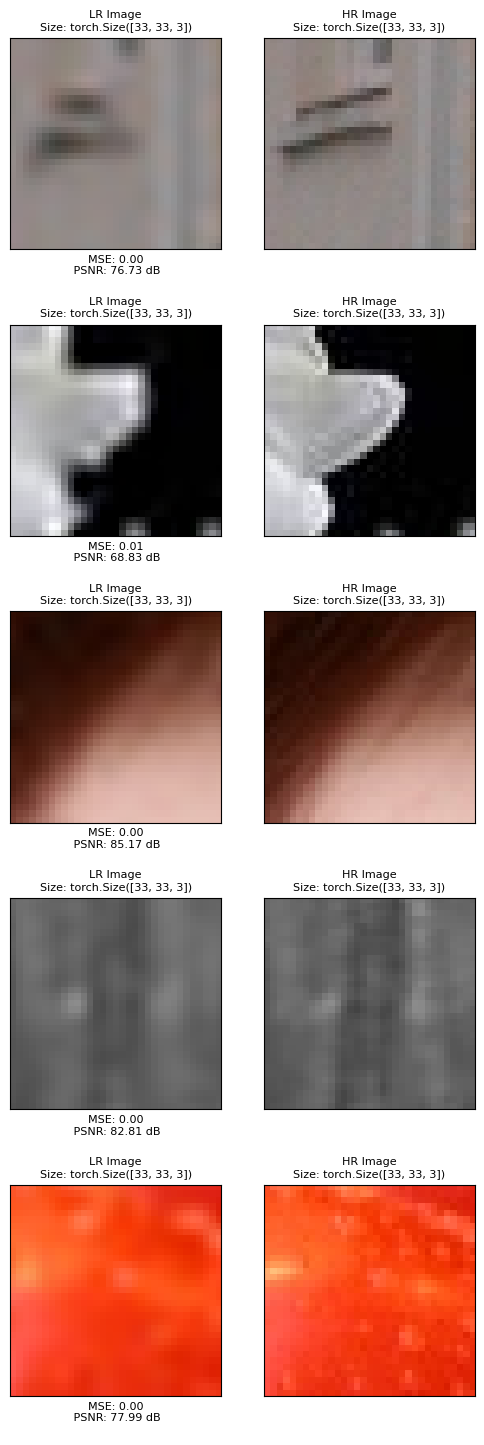

In [45]:
# Display random images from custom created Dataset
display_random_images(dataset=train_data_custom,
                      n=5,
                      seed=None)

## 4.3 Try a forward pass on a single image(to test the model)

In [46]:
# Get a single batch of images
img_batch, label_batch = next(iter(train_dataloader_custom))
img_batch.shape, label_batch.shape

(torch.Size([64, 3, 33, 33]), torch.Size([64, 3, 33, 33]))

In [ ]:
# Try a forward pass
model_0(img_batch.to(device))

# 5.0 Tracking experiments

In [48]:
%%capture
try:
  import wandb
except:
  !pip install wandb
  import wandb

In [49]:
import os

# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

In [50]:
# Log in to your W&B account
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: pershadmayank. Use `wandb login --relogin` to force relogin


True

## 5.1 Config

In [51]:
# Initialize a W&B run
import wandb
wandb.init(project='SRCNN', entity='pershadmayank', config={
    'start_epoch': 0,
    'end_epoch': 2000,
    'learning_rate_first_two_layers': 4e-4,
    'learning_rate_last_layer': 4e-5,
    'architecture': 'SRCNN',
    'kernel_sizes': arch,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'input_channels': color_channel,
    'output_channels': color_channel,
    'padding': padding,
    'checkpoint_interval': 300  # Added to config for flexibility
})

## 5.2 Setup Loss function and optimizer

In [52]:
import torch.nn as nn
import torch

# Set the random seed for reproducibility
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Access hyperparameters from wandb.config
config = wandb.config

# Recreate an instance of SRCNN Model using the wandb config
model = SRCNN(input_channels=config.input_channels,
                     hidden_units_1=config.hidden_units_1,
                     hidden_units_2=config.hidden_units_2,
                     kernel_sizes=config.kernel_sizes,
                     padding=padding,
                     output_channels=config.output_channels).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model.conv_block_1.parameters())
last_layer_params = list(model.conv_block_2.parameters())

# Setup the optimizer with learning rates from wandb.config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config.learning_rate_first_two_layers},
    {'params': last_layer_params, 'lr': config.learning_rate_last_layer}
])

# Setup the loss function
loss_fn = nn.MSELoss()

In [53]:
model_name = str(input("Enter model name:"))

In [54]:
# Train the model using the wandb.config values
model_results = train(model=model,
                      train_dataloader=train_dataloader_custom,
                      test_dataloader=validation_dataloader_custom,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      path=model_name,
                      start_epoch=config.start_epoch,
                      end_epoch=config.end_epoch,
                      device=device,
                      checkpoint_interval=config.checkpoint_interval)

  0%|          | 1/2000 [00:07<4:12:13,  7.57s/it]

Epoch: 1 | train_loss: 0.0341 | val_loss: 0.0116 | train_psnr: 15.71 dB | val_psnr: 19.76 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_0.pth'


 10%|█         | 201/2000 [25:35<3:48:47,  7.63s/it]

Epoch: 201 | train_loss: 0.0027 | val_loss: 0.0038 | train_psnr: 25.74 dB | val_psnr: 25.81 dB


 15%|█▌        | 301/2000 [38:19<3:34:22,  7.57s/it]

Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_300.pth'


 20%|██        | 401/2000 [51:07<3:29:46,  7.87s/it]

Epoch: 401 | train_loss: 0.0026 | val_loss: 0.0038 | train_psnr: 25.91 dB | val_psnr: 25.86 dB


 30%|███       | 601/2000 [1:16:32<2:54:02,  7.46s/it]

Epoch: 601 | train_loss: 0.0025 | val_loss: 0.0038 | train_psnr: 26.00 dB | val_psnr: 25.89 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_600.pth'


 40%|████      | 801/2000 [1:42:07<2:32:43,  7.64s/it]

Epoch: 801 | train_loss: 0.0025 | val_loss: 0.0038 | train_psnr: 26.05 dB | val_psnr: 25.86 dB


 45%|████▌     | 901/2000 [1:54:57<2:22:42,  7.79s/it]

Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_900.pth'


 50%|█████     | 1001/2000 [2:07:40<2:07:08,  7.64s/it]

Epoch: 1001 | train_loss: 0.0025 | val_loss: 0.0038 | train_psnr: 26.09 dB | val_psnr: 25.88 dB


 60%|██████    | 1201/2000 [2:33:20<1:42:11,  7.67s/it]

Epoch: 1201 | train_loss: 0.0025 | val_loss: 0.0038 | train_psnr: 26.12 dB | val_psnr: 25.86 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_1200.pth'


 70%|███████   | 1401/2000 [2:59:00<1:18:06,  7.82s/it]

Epoch: 1401 | train_loss: 0.0025 | val_loss: 0.0039 | train_psnr: 26.15 dB | val_psnr: 25.81 dB


 75%|███████▌  | 1501/2000 [3:12:10<1:10:02,  8.42s/it]

Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_1500.pth'


 80%|████████  | 1601/2000 [3:25:09<51:53,  7.80s/it]  

Epoch: 1601 | train_loss: 0.0025 | val_loss: 0.0038 | train_psnr: 26.15 dB | val_psnr: 25.86 dB


 90%|█████████ | 1801/2000 [3:51:00<26:02,  7.85s/it]

Epoch: 1801 | train_loss: 0.0024 | val_loss: 0.0039 | train_psnr: 26.18 dB | val_psnr: 25.82 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_1800.pth'


100%|██████████| 2000/2000 [4:16:38<00:00,  7.70s/it]

Epoch: 2000 | train_loss: 0.0024 | val_loss: 0.0039 | train_psnr: 26.19 dB | val_psnr: 25.82 dB
Checkpoint saved at '/home/mpershad/Documents/Python/SRCNN/Checkpoints/model5_rgb_9_3_5/epoch_1999.pth'


Total training time: 15399.063 seconds


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_training_time,▁
train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_psnr,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▄▂▁▁▁▁▁▂▁▂▂▂▂▂▂▂▁▂▂▁▁▁▃▃▃▁▂▁▃▂▂▂▂▃▂▃▁▂▂
val_psnr,▁▄▇▇▇█▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▅▅███▆▇▇▇▆▆▇▆█▇▇
epoch,1999
total_training_time,15399.06283
train_loss,0.00243
train_psnr,26.18647
val_loss,0.00386


## 5.3 Save Results Dictionary

In [56]:
import pickle
import os

metrics_path = f'../Metrics'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

pickle_file_path = os.path.join(metrics_path, f"metrics_{model_name}.pkl")


with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_results, file)

print(f"Results saved to {pickle_file_path}")

Results saved to ../Metrics/metrics_model4_rgb_9_3_5.pkl


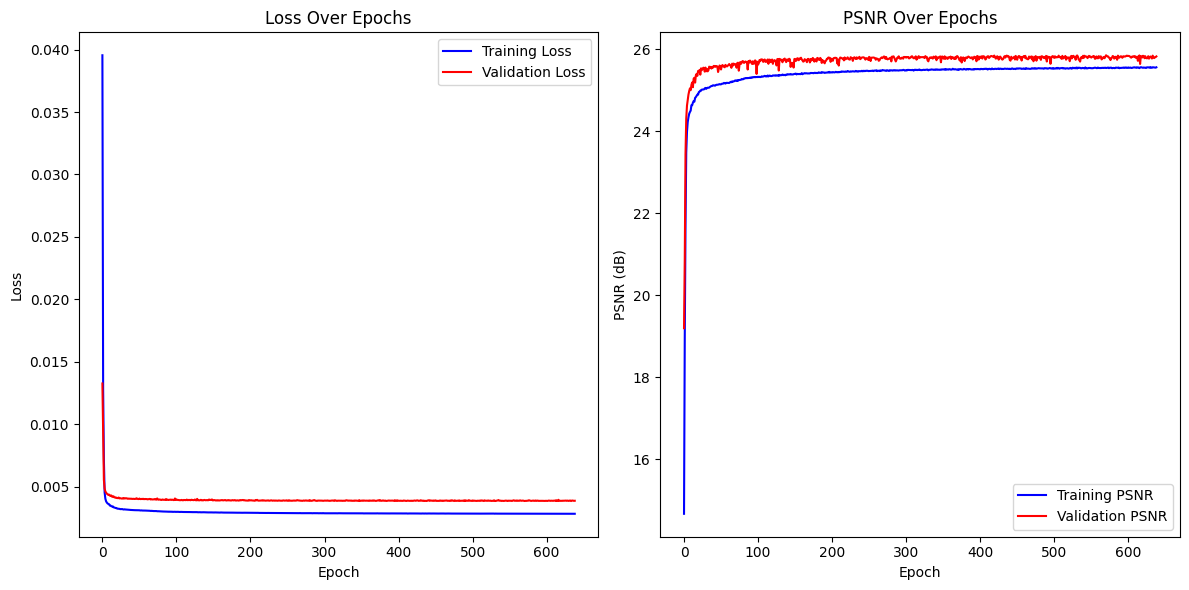

In [58]:
plot_loss_curves(model_results)

# 6.0 Loading Pre-Trained Model

In [ ]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
%%capture
!pip install wandb

In [ ]:
import os

# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

## 6.1 Log In

In [ ]:
import wandb

# Initialize W&B web client
api = wandb.Api()

## 6.2 Connect to the specific project run

In [ ]:
# Define the wandb entity and project
project_name = "SRCNN"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity
run_id = input("Enter runtime ID: ")  # replace with the run ID you want to download from

# Get the specific run
run = api.run(f"{entity_name}/{project_name}/{run_id}")

Enter runtime ID: gevc1x2t


## 6.3 Download the config

In [ ]:
# Download the config.yaml file
config_file = run.file("config.yaml")
config_path = "Config/config.yaml"  # specify your desired path
config_file.download(root="Config", replace=True)

<_io.TextIOWrapper name='Config/config.yaml' mode='r' encoding='UTF-8'>

In [ ]:
%%capture
!pip install pyyaml

In [ ]:
import yaml

# Load the configuration
with open("Config/config.yaml", 'r') as file:
    config_data = yaml.safe_load(file)

## 6.4 Parse the config

In [ ]:
# Resume the wandb run if want to retrain the model
# wandb.init(project=project_name, entity=entity_name, id=run_id, resume="allow", config=config_data)

In [ ]:
config = {}
for k,v in config_data.items():
  if isinstance(v, dict) and 'value' in v:
    config[k] = v['value']
    # if isinstance(v['value'], dict) and 'value' in v['value']:
    #   config[k] = v['value']['value']
    #   if isinstance(v['value']['value'], dict) and 'value' in v['value']:
    #     config[k] = v['value']['value']['value']


In [ ]:
import torch

# Now you can access the configuration values directly
# Recreate an instance of SRCNN Model using the parsed config
model = SRCNN(input_shape=config['input_shape'],
                     hidden_units_1=config['hidden_units_1'],
                     hidden_units_2=config['hidden_units_2'],
                     kernel_sizes=config['kernel_sizes'],
                     output_shape=config['output_shape']).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model.conv_block_1.parameters())
last_layer_params = list(model.conv_block_2.parameters())

# Setup the optimizer with learning rates from the parsed config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config['learning_rate_first_two_layers']},
    {'params': last_layer_params, 'lr': config['learning_rate_last_layer']}
])

# Setup the loss function
loss_fn = custom_mse_loss

In [ ]:
# Get the artifact using the API
artifact = api.artifact("pershadmayank/SRCNN/SRCNN:v12", type="model")

# Use the artifact in your current run
run = wandb.init()
artifact_obj = run.use_artifact(artifact)

# Download the artifact's contents
artifact_dir = artifact_obj.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
import os
import glob

# Assuming artifact_dir is the directory where the artifact is downloaded
model_path = glob.glob(os.path.join(artifact_dir, "*.pth"))

if not model_path:
    raise FileNotFoundError("No .pth file found in the artifact directory.")

model_path[0]

'/content/artifacts/SRCNNModel:v12/model8_9_3_5.pth'

In [ ]:
# Load the checkpoint
checkpoint = torch.load(model_path[0], map_location=device)  # or 'cuda' if using GPU

# Apply the loaded state dictionaries to the model and optimizer
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to the desired device
model.to(device)

SRCNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

# 7.0 Inference using trained Model


In [55]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# /content/SRCNN/Data/Test/LR/baboon.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Test/HR/baboon.bmp"

# Convert BMP to JPEG or PNG
hr_img = Image.open(test_img_path).convert('RGB')
hr_img = np.array(hr_img)
# hr_img_ycbcr = hr_img.convert('YCbCr')

# # Convert images to numpy arrays
# hr_img_array = np.array(hr_img_ycbcr)

# hr_img_array = modcrop(hr_img_array, scale)

# # Take the y channel
# y_channel = hr_img_array[:, :, 0]

test_img = generate_lr_image(hr_img, operation, scale, kernel_size, sigma)

# Convert the Y channel image to a PyTorch tensor
test_img_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Convert RGB to Y channel and get Image Tensor
test_img_tensor = test_img_transform(test_img)

# Move the tensor to the designated device
test_img_tensor = test_img_tensor.to(device)

# Print out image data
print(f"Test Image Tesnor:\n {test_img_tensor}\n")
print(f"Test Image Shape: {test_img_tensor.shape}")
print(f"Test Image stype: {test_img_tensor.dtype}")

Test Image Tesnor:
 tensor([[[0.7137, 0.6627, 0.4980,  ..., 0.3333, 0.1882, 0.1412],
         [0.6588, 0.6118, 0.4627,  ..., 0.3137, 0.1804, 0.1373],
         [0.5020, 0.4667, 0.3529,  ..., 0.2510, 0.1490, 0.1137],
         ...,
         [0.2902, 0.2941, 0.3020,  ..., 0.1922, 0.1882, 0.1843],
         [0.2784, 0.2824, 0.2902,  ..., 0.1843, 0.1725, 0.1686],
         [0.2745, 0.2784, 0.2863,  ..., 0.1843, 0.1686, 0.1647]],

        [[0.6863, 0.6353, 0.4863,  ..., 0.4431, 0.3137, 0.2706],
         [0.6353, 0.5882, 0.4510,  ..., 0.4157, 0.2980, 0.2588],
         [0.4902, 0.4549, 0.3451,  ..., 0.3412, 0.2549, 0.2235],
         ...,
         [0.3608, 0.3686, 0.3922,  ..., 0.1725, 0.1569, 0.1529],
         [0.3333, 0.3451, 0.3765,  ..., 0.1804, 0.1608, 0.1529],
         [0.3216, 0.3333, 0.3725,  ..., 0.1843, 0.1608, 0.1529]],

        [[0.1529, 0.1412, 0.1098,  ..., 0.2471, 0.1922, 0.1765],
         [0.1412, 0.1333, 0.1059,  ..., 0.2314, 0.1804, 0.1647],
         [0.1098, 0.1059, 0.0824,  ...

In [56]:
test_img_tensor.shape, test_img_tensor.unsqueeze(dim=0).shape

(torch.Size([3, 480, 500]), torch.Size([1, 3, 480, 500]))

In [57]:
# Set it to evaluation mode
model.eval()
with torch.inference_mode():
  img_predicted = model(test_img_tensor.unsqueeze(dim=0).to(device))

In [58]:
img_predicted = img_predicted.cpu().squeeze()

# Rearrange the channels
img_predicted = img_predicted.permute(1, 2, 0)

# Convert to numpy array
img_predicted = img_predicted.numpy() * 255
img_predicted = img_predicted.astype(np.uint8)

img_predicted.shape

(480, 500, 3)

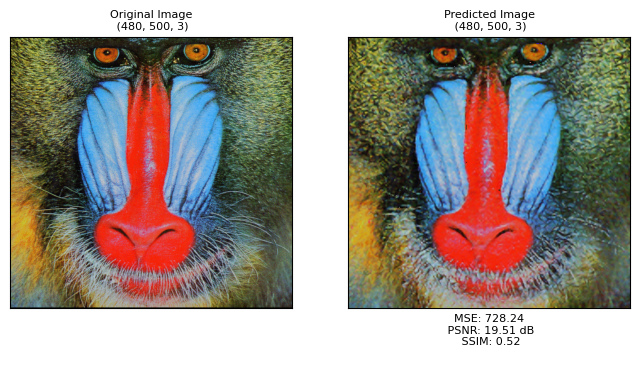

In [59]:
import matplotlib.pyplot as plt

# Calculate the combined metrics
metrics = combined_metric(hr_img, img_predicted)
metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(hr_img)
plt.title(f"Original Image\n {hr_img.shape}", fontsize=8)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_predicted)
plt.title(f"Predicted Image\n {img_predicted.shape}", fontsize=8)
plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
plt.xticks([])
plt.yticks([])
plt.show()

**Note:** To make a prediction using the trained SRCNN model on a custom image:

1. Load the image using PIL and ensure it's in RGB format.
2. Convert the RGB image to YCbCr format and extract the Y channel.
3. Apply necessary transformations to the Y channel (e.g., resize, convert to tensor).
4. Add a batch dimension to the tensor to make it suitable for the model.
5. Set the model to evaluation mode using `model.eval()`.
6. Move the tensor to the same device as the model (if using GPU).
7. Pass the tensor through the model to get the predicted Y channel.
8. Resize the original Cb and Cr channels to match the predicted Y channel's dimensions (if necessary).
9. Merge the predicted Y channel with the resized Cb and Cr channels.
10. Convert the resulting YCbCr image back to RGB.
11. Visualize or save the resulting RGB image.

Ensure that all tensors are of the correct datatype (typically `torch.float32`) and that the preprocessing steps match those used during the model's training phase.


In [64]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2 as cv

def pred_and_plot_image(model: torch.nn.Module, image_path: str, transform=None, plot=False, device: torch.device = torch.device('cpu')):
  # Load image and convert
  hr_img = Image.open(image_path).convert('RGB')
  hr_img_ycbcr = hr_img.convert('YCbCr')
  hr_img_array = np.array(hr_img_ycbcr)

  hr_img_array = modcrop(hr_img_array, scale)

  y_channel = hr_img_array[:, :, 0]  # Take the Y channel
  test_img = generate_lr_image(y_channel, operation, scale, kernel_size, sigma)

  if transform is None:
    transform = transforms.Compose([transforms.ToTensor()])

  test_img_tensor = transform(test_img).to(device)

  # Inference
  model.eval()
  with torch.inference_mode():
      y_predicted = model(test_img_tensor.unsqueeze(0))

  # Process the output
  y_predicted = y_predicted.squeeze().cpu().numpy() * 255
  y_predicted = y_predicted.astype(np.uint8)

  # Crop original channels to match the predicted Y size
  target_height, target_width = y_predicted.shape
  y, Cb, Cr = crop(hr_img_array[:, :, 0], target_height, target_width), \
              crop(hr_img_array[:, :, 1], target_height, target_width), \
              crop(hr_img_array[:, :, 2], target_height, target_width)

  # Combine and convert for plotting
  cropped_ycbcr = np.stack((y, Cb, Cr), axis=-1).astype(np.uint8)
  predicted_ycbcr = np.stack((y_predicted, Cb, Cr), axis=-1).astype(np.uint8)
  cropped_rgb = cv.cvtColor(cropped_ycbcr, cv.COLOR_YCrCb2BGR)
  predicted_rgb = cv.cvtColor(predicted_ycbcr, cv.COLOR_YCrCb2BGR)


  if plot:
    metrics = combined_metric(cropped_rgb, predicted_rgb)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_rgb)
    plt.title("Original HR Image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_rgb)
    plt.title("Predicted Image")
    plt.xlabel(metrics_str)
    plt.xticks([])
    plt.yticks([])
    plt.show()
  return cropped_rgb, predicted_rgb

In [ ]:
# /content/SRCNN/Data/Test/LR/lenna.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "/content/SRCNN/Data/Test/HR/lenna.bmp"

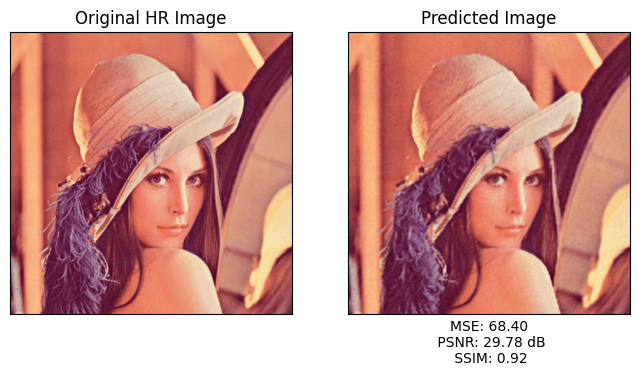

In [ ]:
pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                image_path=test_img_path,  # Replace with the path to your image
                                transform=test_img_transform,  # The transformation to apply
                                device=device,  # The device (cpu or cuda)
                                plot=True)

In [ ]:
from PIL import Image
import pandas as pd


# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Filename', 'MSE', 'PSNR', 'SSIM'])

# Instead of using append in a loop, collect your rows in a list
rows_to_add = []

test_img_dir = "/content/SRCNN/Data/Test/HR"
for f in os.listdir(test_img_dir):

  filename = f.split('.')[0]

  image_path = os.path.join(test_img_dir, f)

  # Get the predicted image
  cropped_img, predicted_img = pred_and_plot_image(model=model,
                                      image_path=os.path.join(test_img_dir, f),
                                      transform=test_img_transform,
                                      device=device,
                                      plot=False)

  # Compute metrics
  metrics = combined_metric(cropped_img, predicted_img)

  # Append the row as a dictionary to the list
  rows_to_add.append({'Filename': filename, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2]})

results_df = pd.concat([results_df, pd.DataFrame(rows_to_add)], ignore_index=True)

In [ ]:
set5 = [1, 12, 13, 15, 16]
set5_df = results_df.iloc[set5].reset_index(drop=True)
avg_psnr =set5_df['PSNR'].mean()
print(f"Average PSNR: {avg_psnr:.2f}dB")
set5_df

Average PSNR: 28.67dB


,Filename,MSE,PSNR,SSIM
0,bird_GT,49.951258,31.145339,0.957547
1,baby_GT,42.857586,31.810527,0.942953
2,head_GT,59.682796,30.372312,0.877014
3,woman_GT,125.719066,27.136792,0.923862
4,butterfly_GT,334.392549,22.888238,0.895513


In [ ]:
set14_df = results_df.drop(set5).reset_index(drop=True)
avg_psnr = set14_df['PSNR'].mean()
print(f"Average PSNR: {avg_psnr:.2f}dB")
set14_df

Average PSNR: 25.25dB


,Filename,MSE,PSNR,SSIM
0,face,59.648039,30.374842,0.876846
1,ppt3,999.662040,18.132272,0.834093
2,pepper,59.302509,30.400073,0.924708
3,foreman,62.135650,30.197395,0.944650
4,flowers,200.005565,25.120383,0.862466
5,bridge,305.369720,23.282544,0.747404
6,baboon,566.076727,20.602051,0.642452
7,lenna,68.398416,29.780343,0.916291
8,comic,547.960562,20.743311,0.757474
9,barbara,282.971632,23.613375,0.811292
